In [1]:
from functools import partial
from multiprocessing import Pool
from typing import Tuple, Union

import numpy as np
import torch

from pyvrp import (
    Model,
    Client,
    CostEvaluator,
    Depot,
    ProblemData,
    RandomNumberGenerator,
    Solution,
    VehicleType,
)
from pyvrp.search import (
    NODE_OPERATORS,
    ROUTE_OPERATORS,
    LocalSearch,
    NeighbourhoodParams,
    compute_neighbours,
)
from pyvrp.stop import MaxRuntime
from tensordict.tensordict import TensorDict

from rl4co.utils.ops import get_distance_matrix
from rl4co.utils.pylogger import get_pylogger

In [2]:
COORDS = [
    (456, 320),  # location 0 - the depot
    (556, 320),  # location 0 - the depot
    (456, 420),  # location 0 - the depot
    (456, 520),  # location 0 - the depot
    (228, 0),    # location 1
    (912, 0),    # location 2
    (0, 80),     # location 3
    (114, 80),   # location 4
    (570, 160),  # location 5
    (798, 160),  # location 6
    (342, 240),  # location 7
    (684, 240),  # location 8
    (570, 400),  # location 9
    (912, 400),  # location 10
    (114, 480),  # location 11
    (228, 480),  # location 12
    (342, 560),  # location 13
    (684, 560),  # location 14
    (0, 640),    # location 15
    (798, 640),  # location 16
]
DEMANDS = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]



DURATION_MATRIX = [
        [0, 6, 9, 8, 7, 3, 6, 2, 3, 2, 6, 6, 4, 4, 5, 9, 7],
        [6, 0, 8, 3, 2, 6, 8, 4, 8, 8, 13, 7, 5, 8, 12, 10, 14],
        [9, 8, 0, 11, 10, 6, 3, 9, 5, 8, 4, 15, 14, 13, 9, 18, 9],
        [8, 3, 11, 0, 1, 7, 10, 6, 10, 10, 14, 6, 7, 9, 14, 6, 16],
        [7, 2, 10, 1, 0, 6, 9, 4, 8, 9, 13, 4, 6, 8, 12, 8, 14],
        [3, 6, 6, 7, 6, 0, 2, 3, 2, 2, 7, 9, 7, 7, 6, 12, 8],
        [6, 8, 3, 10, 9, 2, 0, 6, 2, 5, 4, 12, 10, 10, 6, 15, 5],
        [2, 4, 9, 6, 4, 3, 6, 0, 4, 4, 8, 5, 4, 3, 7, 8, 10],
        [3, 8, 5, 10, 8, 2, 2, 4, 0, 3, 4, 9, 8, 7, 3, 13, 6],
        [2, 8, 8, 10, 9, 2, 5, 4, 3, 0, 4, 6, 5, 4, 3, 9, 5],
        [6, 13, 4, 14, 13, 7, 4, 8, 4, 4, 0, 10, 9, 8, 4, 13, 4],
        [6, 7, 15, 6, 4, 9, 12, 5, 9, 6, 10, 0, 1, 3, 7, 3, 10],
        [4, 5, 14, 7, 6, 7, 10, 4, 8, 5, 9, 1, 0, 2, 6, 4, 8],
        [4, 8, 13, 9, 8, 7, 10, 3, 7, 4, 8, 3, 2, 0, 4, 5, 6],
        [5, 12, 9, 14, 12, 6, 6, 7, 3, 3, 4, 7, 6, 4, 0, 9, 2],
        [9, 10, 18, 6, 8, 12, 15, 8, 13, 9, 13, 3, 4, 5, 9, 0, 9],
        [7, 14, 9, 16, 14, 8, 5, 10, 6, 5, 4, 10, 8, 6, 2, 9, 0],
]

In [3]:
from rl4co.envs.routing.evrptw.generator import MTSPGenerator
from rl4co.envs.routing.evrptw.env import MTSPEnv

C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\torchrl\data\replay_buffers\samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)


In [4]:
from rl4co.models import MatNetPolicy, MatNet

if torch.cuda.is_available():
    accelerator = "gpu"
    batch_size = 256
    train_data_size = 5_000
    embed_dim = 128
    num_encoder_layers = 4
else:
    accelerator = "cpu"
    batch_size = 16
    train_data_size = 5_000
    embed_dim = 128
    num_encoder_layers = 2
    
env = MTSPEnv(generator_params={"n_customers": 12, "min_num_agents": 4, "max_num_agents": 4})
policy = MatNetPolicy()
model = MatNet(env=env,
               policy=policy,
               baseline="shared",
               batch_size=batch_size,
               train_data_size=train_data_size,
               val_data_size=2_000)

Found 4 unused kwargs: {'embed_dim': 256, 'num_encoder_layers': 5, 'num_heads': 16, 'normalization': 'instance'}
C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


In [5]:
td_init = env.reset(batch_size=[4])

In [6]:
from rl4co.utils import RL4COTrainer

trainer = RL4COTrainer(max_epochs=1, devices="auto")
trainer.fit(model)

C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\accelerator_connector.py:512: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
val_file

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\zm0714\Documents\Projekte\rl4co-slap\venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [93]:
out = policy(td_init.clone(), env, phase="test", decode_type="beam_search", return_actions=True)
print(out["reward"])

tensor([ -9.6438,  -8.7471,  -7.3721, -20.9266])


tensor(9.6438)
{1: 0, 2: 0, 3: 0, 4: 0}
{1: [100, tensor(97.9753), tensor(94.0651), tensor(91.7031), tensor(87.7500), tensor(85.6438)], 2: [100, tensor(97.7497), tensor(95.5745), tensor(91.9037), tensor(88.5084), tensor(85.5569), tensor(82.9020), tensor(80.7124)], 3: [100, tensor(96.1309), tensor(93.4193)], 4: [100, tensor(97.7368), tensor(95.4529)]}
tensor(8.7471)
{1: 0, 2: 0, 3: 0, 4: 0}
{1: [100, tensor(96.6335), tensor(93.3280), tensor(91.0515), tensor(88.4741), tensor(85.4707), tensor(82.5057)], 2: [100, tensor(97.6657), tensor(93.8153), tensor(89.9688), tensor(87.7936)], 3: [100, tensor(97.6397), tensor(94.5640)], 4: [100, tensor(96.3881), tensor(93.7103), tensor(90.4538), tensor(86.5693)]}
tensor(7.3721)
{1: 0, 2: 0, 3: 0, 4: 0}
{1: [100, tensor(97.7563), tensor(94.2953), tensor(92.2683), tensor(89.2294), tensor(85.2559)], 2: [100, tensor(97.8539), tensor(94.6131), tensor(91.3424), tensor(88.4891), tensor(85.6530)], 3: [100, tensor(97.2548), tensor(94.8794)], 4: [100, tensor(96.

C:\Users\zm0714\AppData\Local\Temp\ipykernel_34108\1602695519.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


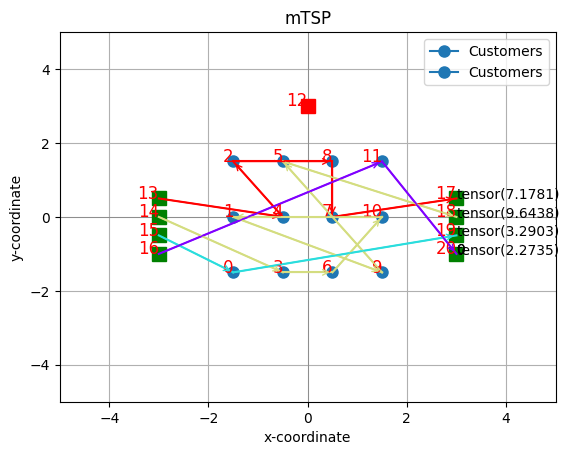

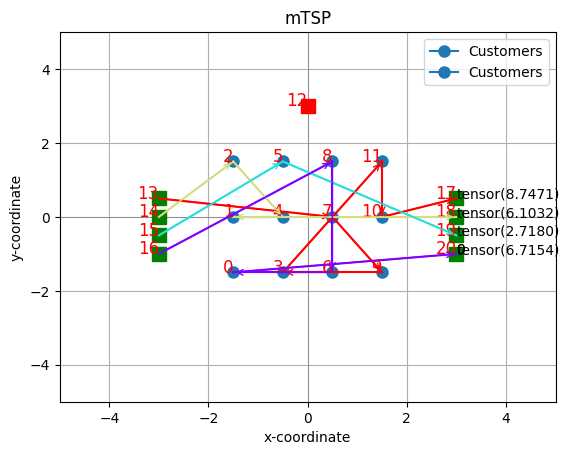

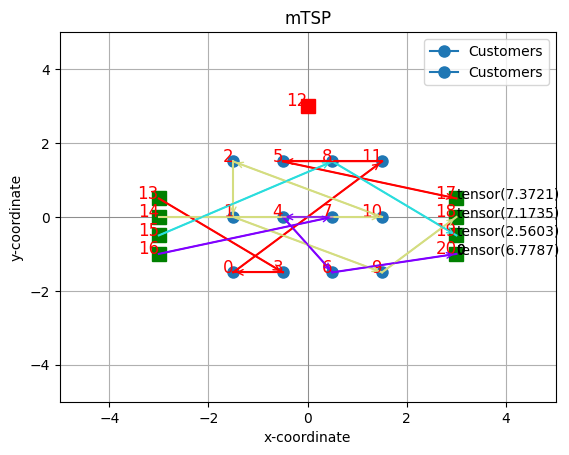

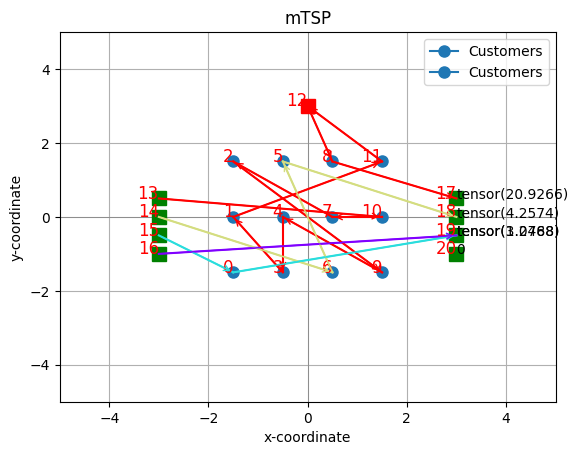

In [94]:
for td, actions in zip(td_init, out['actions'].cpu()):
    fig = env.render(td, actions)
    fig.show()

In [9]:
TIME_WINDOWS = [
    (0, 500),
    (0, 10),  # location 2
    (0, 15),  # location 3
    (0, 20),  # location 4
    (0, 25),    # location 5
    (0, 30),   # location 6
    (0, 30),    # location 7
    (0, 30),   # location 8
    (0, 30),    # location 9
    (0, 30),  # location 10
    (0, 30),  # location 11
    (0, 30),    # location 12
]

In [75]:
from copy import deepcopy

td = deepcopy(td_init[3])
DURATION_MATRIX = td["cost_matrix"].detach().cpu().numpy()

num_agents = td["num_agents"].numpy()
num_points = td["customer_nodes"].shape[-1]
# locs = td["locs"]

cols = int(np.ceil(np.sqrt(num_points)))
rows = int(np.ceil(num_points / cols))

# Generate the rectangular spread coordinates
rectangular_spread = [(x, y) for x in np.linspace(
    -1.5, 1.5, cols) for y in np.linspace(-1.5, 1.5, rows)]
rectangular_spread = rectangular_spread[:num_points]
max_coord = max(rectangular_spread)
y_cs = max_coord[0] + 1.5
# Limit to the number of points needed
top_point = [(0, y_cs)]

y_values = np.linspace(0.5, -1, num_agents)
left_points = [(-3, y) for y in y_values]  # Points going down on the left
right_points = [(3, y) for y in y_values]
# Updating all points
all_points = rectangular_spread + top_point + left_points + right_points

In [76]:
# TIME_WINDOWS = td["time_windows"][0:12].detach().cpu().numpy()

In [77]:
m = Model()

In [78]:
depots = []
for idx in range(num_agents):
    depot_start = m.add_depot(x=left_points[idx][0], y=right_points[idx][1])
    print(depot_start)
    depot_end = m.add_depot(x=right_points[idx][0], y=right_points[idx][1])
    # Two vehicles at each depot, with 30 maximum route duration.
    m.add_vehicle_type(
        1,
        start_depot=depot_start,
        end_depot=depot_end,
        max_duration=20,
        # tw_early=0,
        # tw_late=30,
    )
    depots.append(depot_start)
    depots.append(depot_end)

In [79]:
# for idx in range(len(rectangular_spread)):
#     m.add_client(
#         x=rectangular_spread[idx][0],
#         y=rectangular_spread[idx][1],
#         # tw_early=TIME_WINDOWS[idx][0],
#         # tw_late=TIME_WINDOWS[idx][1],
#     )
clients = [m.add_client(
        x=rectangular_spread[idx][0],
        y=rectangular_spread[idx][1],
        # tw_early=TIME_WINDOWS[idx][0],
        # tw_late=TIME_WINDOWS[idx][1],
    ) for idx in range(len(rectangular_spread))]

In [80]:
DURATION_MATRIX *= 10

In [81]:
DURATION_MATRIX

array([[ 0.       , 11.626049 , 14.332515 , 13.46648  , 19.093187 ,
        14.989142 , 12.207211 , 12.376877 , 13.420448 , 13.175823 ,
        10.8455105, 12.40844  , 10.62696  , 16.440966 , 11.201057 ,
        12.810582 , 10.683055 , 19.874163 , 13.920541 , 15.717951 ,
        13.118217 ],
       [16.38008  ,  0.       , 11.9323845, 18.382528 , 10.561306 ,
        17.1145   , 18.71021  , 15.583698 , 18.19975  , 19.729752 ,
        10.153406 , 13.187294 , 15.285993 , 19.431057 , 13.755956 ,
        19.234285 , 18.369944 , 16.628632 , 16.301525 , 15.58022  ,
        14.303196 ],
       [19.885155 , 11.500157 ,  0.       , 15.834497 , 12.876808 ,
        10.9309845, 10.324438 , 19.431671 , 13.9437   , 17.032234 ,
        15.734482 , 16.054482 , 60.305195 , 15.1926365, 10.906307 ,
        19.02478  , 11.776075 , 10.745268 , 14.680219 , 18.935184 ,
        12.433691 ],
       [17.76312  , 14.985083 , 17.325115 ,  0.       , 18.092249 ,
        17.802876 , 19.702187 , 11.471776 , 10.352194

In [63]:
# customers = m.locations[8:]

In [64]:
# depots = m.locations[0:8]

In [82]:
locations = clients + depots 

In [83]:
locations

In [84]:
for frm_idx, frm in enumerate(locations):
    for to_idx, to in enumerate(locations):
        distance = DURATION_MATRIX[frm_idx][to_idx] 
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

In [85]:
res = m.solve(stop=MaxRuntime(1), display=False)  # one second
print(res)

Solution results
    # routes: 4
   # clients: 12
   objective: INFEASIBLE
    distance: 230
    duration: 230
# iterations: 1574
    run-time: 1.00 seconds

Routes
------
Route #1: 16 9 12 
Route #2: 14 13 19 
Route #3: 11 17 18 
Route #4: 15 10 8 



In [22]:
res.best.routes()[0].visits()

[16, 9, 12]

In [23]:
res.best.routes()[0].start_depot()

0

In [24]:
DURATION_MATRIX[0,16]

10.683055

In [25]:
DURATION_MATRIX[16,9]

16.139967

In [26]:
DURATION_MATRIX[9, 12]


15.718131

In [27]:
DURATION_MATRIX[12, 1]

18.271801

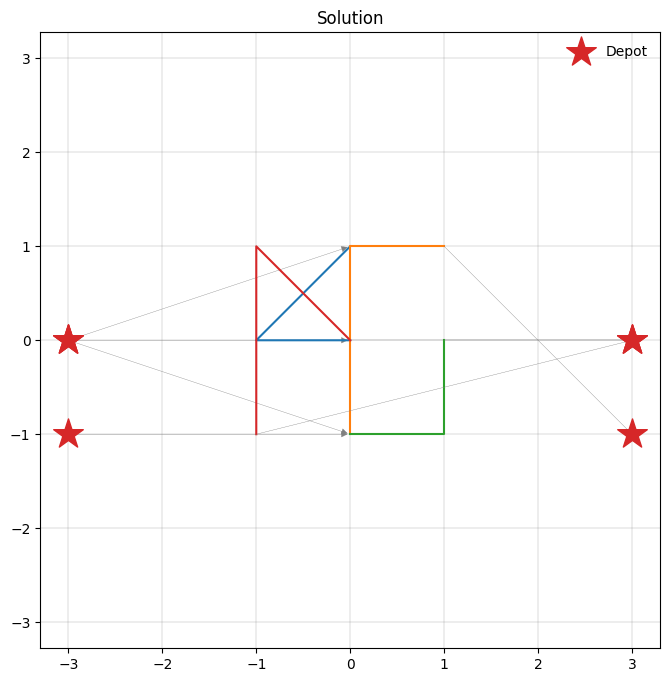

In [28]:
import matplotlib.pyplot as plt
from pyvrp.plotting import plot_solution
_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), ax=ax)

In [87]:
COORDS = [
    (456, 320),  # location 0 - the depot
    (228, 0),    # location 1
    (912, 0),    # location 2
    (0, 80),     # location 3
    (114, 80),   # location 4
    (570, 160),  # location 5
    (798, 160),  # location 6
    (342, 240),  # location 7
    (684, 240),  # location 8
    (570, 400),  # location 9
    (912, 400),  # location 10
    (114, 480),  # location 11
    (228, 480),  # location 12
    (342, 560),  # location 13
    (684, 560),  # location 14
    (0, 640),    # location 15
    (798, 640),  # location 16
]
DEMANDS = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]

TIME_WINDOWS = [
    (0, 999),  # location 0 - a depot (modified to be unrestricted)
    (0, 999),  # location 1 - a depot (modified to be unrestricted)
    (10, 15),  # location 2
    (16, 18),  # location 3
    (10, 13),  # location 4
    (0, 5),    # location 5
    (5, 10),   # location 6
    (0, 4),    # location 7
    (5, 10),   # location 8
    (0, 3),    # location 9
    (10, 16),  # location 10
    (10, 15),  # location 11
    (0, 5),    # location 12
    (5, 10),   # location 13
    (7, 8),    # location 14
    (10, 15),  # location 15
    (11, 15),  # location 16
]

m = Model()

for idx in range(2):
    depot = m.add_depot(x=COORDS[idx][0], y=COORDS[idx][1])

    # Two vehicles at each depot, with 30 maximum route duration.
    m.add_vehicle_type(
        2,
        start_depot=depot,
        end_depot=depot,
        max_duration=30,
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )

for idx in range(2, len(COORDS)):
    m.add_client(
        x=COORDS[idx][0],
        y=COORDS[idx][1],
        tw_early=TIME_WINDOWS[idx][0],
        tw_late=TIME_WINDOWS[idx][1],
    )

for frm_idx, frm in enumerate(m.locations):
    for to_idx, to in enumerate(m.locations):
        distance = abs(frm.x - to.x) + abs(frm.y - to.y)  # Manhattan
        duration = DURATION_MATRIX[frm_idx][to_idx]
        m.add_edge(frm, to, distance=distance, duration=duration)

In [88]:
res = m.solve(stop=MaxRuntime(1), display=False)  # one second
print(res)

Solution results
    # routes: 4
   # clients: 15
   objective: INFEASIBLE
    distance: 12416
    duration: 322
# iterations: 814
    run-time: 1.00 seconds

Routes
------
Route #1: 11 5 8 14 
Route #2: 10 3 2 4 
Route #3: 15 13 9 16 
Route #4: 7 12 6 



In [3]:
# Copyright (c) 2023 Patrick S. Klein (@libklein)
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

import copy

import routingblocks as rb
import random


def create_random_solution(evaluation: rb.Evaluation, instance: rb.Instance):
    customer_vertex_ids = [x.vertex_id for x in instance.customers]
    random.shuffle(customer_vertex_ids)

    # Draw a sequence of positions where to split
    number_of_splits = random.randint(1, len(customer_vertex_ids) // 2)
    split_positions = [0, *sorted(random.sample(range(1, len(customer_vertex_ids) - 1), number_of_splits)),
                       len(customer_vertex_ids)]
    # Create routes according to the split positions. Each route is a list of customer vertex ids.
    routes = [customer_vertex_ids[route_start_index:route_end_index] for route_start_index, route_end_index in
              zip(split_positions, split_positions[1:])]
    # Create RoutingBlocks Route objects
    routes = [rb.create_route(evaluation, instance, route) for route in routes]
    # Create RoutingBlocks Solution object
    return rb.Solution(evaluation, instance, routes)


def perturb(solution: rb.Solution, max_exchanges: int) -> rb.Solution:
    assert sum(1 for r in solution if not r.empty) > 1, "Cannot perturb a solution with only one route."
    # Create a new solution by copying the current solution
    new_solution = copy.copy(solution)

    # Exchange random sequences between routes
    num_exchanges = random.randint(0, max_exchanges)
    for _ in range(num_exchanges):
        # Select two random routes
        while True:
            route_1 = random.choice(new_solution)
            route_2 = random.choice(new_solution)
            if route_1 is not route_2 and not route_1.empty and not route_2.empty:
                break
        # Select a random sequence of customers in route 1 that does not include the depot
        start_index_1 = random.randint(1, len(route_1) - 2)
        # end_index is exclusive
        end_index_1 = random.randint(start_index_1, len(route_1) - 1)
        # Do the same for the second route
        # Select a random sequence of customers in route 1 that does not include the depot
        start_index_2 = random.randint(1, len(route_2) - 2)
        # end_index is exclusive
        end_index_2 = random.randint(start_index_2, len(route_2) - 1)
        # Exchange the sequences
        new_solution.exchange_segment(route_1, start_index_1, end_index_1,
                                      route_2, start_index_2, end_index_2)
    return new_solution


def iterated_local_search(instance: rb.Instance, vehicle_storage_capacity: float, vehicle_battery_capacity_time: float,
                          number_of_iterations: int = 100):
    evaluation = rb.adptw.Evaluation(vehicle_battery_capacity_time, vehicle_storage_capacity)
    # Set the penalty factors used to penalize violations of the time window, the
    # vehicle capacity, and the charge constraints
    evaluation.overload_penalty_factor = 100.
    evaluation.resource_penalty_factor = 100.0
    evaluation.time_shift_penalty_factor = 100.0

    # Configure the local search to use a best-improvement pivoting rule
    local_search = rb.LocalSearch(instance, evaluation, None, rb.BestImprovementPivotingRule())
    # Create a set of allowed arcs
    arc_set = rb.ArcSet(instance.number_of_vertices)

    # Create a set of operators that will be used later when calling the local search
    operators = [
        rb.operators.SwapOperator_0_1(instance, arc_set),
        rb.operators.SwapOperator_1_1(instance, arc_set),
        rb.operators.InsertStationOperator(instance),
        rb.operators.RemoveStationOperator(instance),
    ]

    best_solution = create_random_solution(evaluation, instance)
    current_solution = copy.copy(best_solution)
    for i in range(number_of_iterations):
        # Search the neighborhood of the current solution. This modifies the solution in-place.
        local_search.optimize(current_solution, operators)
        if current_solution.cost < best_solution.cost:
            best_solution = current_solution
            print(f"New best solution found: {best_solution.cost} ({best_solution.feasible})")

        # Perturb the current solution
        current_solution = perturb(current_solution, len(current_solution) // 2)

    return best_solution

In [4]:
from typing import Callable, Dict, Union
from pathlib import Path
from itertools import product
from math import sqrt
import routingblocks as rb


def parse_instance(instance_path: Path):
    str_fields = ['StringID', 'Type']
    with open(instance_path) as instance_stream:
        fields = instance_stream.readline().split()
        # Parse the vertices
        vertices = []
        for line in instance_stream:
            tokens = line.split()
            if len(tokens) == 0:
                break
            # Read columns into a dictionary
            vertex = {key: (x if key in str_fields else float(x)) for key, x in zip(fields, tokens)}
            vertices.append(vertex)
        # Parse the parameters
        parameters = {}
        for line in instance_stream:
            key, *_, value = line.split()
            # Remove surrounding / characters and parse the value
            parameters[key] = float(value[1:-1])

    # Create a mapping from pairs of vertices to arcs
    arcs = {}
    for i in vertices:
        for j in vertices:
            # Compute distance
            distance = sqrt((i['x'] - j['x']) ** 2 + (i['y'] - j['y']) ** 2)
            # Compute travel time (distance / average velocity)
            travel_time = distance / parameters['v']
            # Compute consumption (consumption rate * travel time / recharging rate)
            consumption = parameters['r'] * travel_time / parameters['g']
            arcs[i['StringID'], j['StringID']] = dict(distance=distance, travel_time=travel_time,
                                                      consumption=consumption)

    return vertices, arcs, parameters


def create_instance(serialized_vertices, serialized_arcs) -> rb.Instance:
    instance_builder = rb.utility.InstanceBuilder(create_vertex=rb.adptw.create_adptw_vertex,
                                                  create_arc=rb.adptw.create_adptw_arc)
    instance_builder.fleet_size = 4
    # Create and register the vertices
    for vertex in serialized_vertices:
        # Create problem-specific data held by vertices
        vertex_data = rb.adptw.VertexData(vertex['x'], vertex['y'], vertex['demand'], vertex['ReadyTime'],
                                          vertex['DueDate'],
                                          vertex['ServiceTime'])
        # Register the vertex depending on it's type
        if vertex['Type'] == 'd':
            instance_builder.set_depot(vertex['StringID'], vertex_data)
        elif vertex['Type'] == 'c':
            instance_builder.add_customer(vertex['StringID'], vertex_data)
        else:
            instance_builder.add_station(vertex['StringID'], vertex_data)

    # Create and register the arcs
    for (i, j), arc in serialized_arcs.items():
        # Create problem-specific data held by arcs
        arc_data = rb.adptw.ArcData(arc['distance'], arc['consumption'], arc['travel_time'])
        instance_builder.add_arc(i, j, arc_data)

    # Create instance
    return instance_builder.build()

In [5]:
from pathlib import Path
import argparse

def solve(instance_path: Path, number_of_iterations: int = 100):
    vertices, arcs, params = parse_instance(instance_path)
    instance = create_instance(vertices, arcs)
    vehicle_storage_capacity = params['C']
    # Vehicle battery capacity in units of time:
    # battery capacity * inverse refueling rate = battery capacity / refueling rate
    vehicle_battery_capacity_time = params['Q'] * params['g']

    solution = iterated_local_search(instance=instance, vehicle_storage_capacity=vehicle_storage_capacity,
                                     vehicle_battery_capacity_time=vehicle_battery_capacity_time,
                                     number_of_iterations=number_of_iterations
                                     )

    print("Best solution:")
    print(solution)
    return solution





In [6]:
# parser = argparse.ArgumentParser(description="Solve a EVRP-TW-PR instance with ILS.")
# 
# parser.add_argument(
#     "instance_path",
#     type=Path,
#     help="Path to the instance file."
# )
# 
# parser.add_argument(
#     "-n", "--number_of_iterations",
#     type=int,
#     default=100,
#     help="Number of ILS iterations to perform (default: 100)."
# )
# 
# args = parser.parse_args()

sol = solve("./instance/c101_21.txt", 100)  

New best solution found: 1346.7725830078125 (True)
New best solution found: 1156.677001953125 (True)
New best solution found: 1118.4293212890625 (True)
New best solution found: 1056.0223388671875 (True)
Best solution:
Solution(cost=1056.02, routes=[[D0,C63,C74,C79,C77,C80,C72,C61,C66,D0,]
[D0,C73,C70,C71,C76,C78,C81,D0,]
[D0,C41,C40,C42,C44,C45,C48,C46,C47,C43,D0,]
[D0,C21,C22,C25,C27,C30,C28,C26,D0,]
[D0,C90,C87,C86,C82,C83,C84,C85,C88,C89,C91,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,C75,C1,C96,C95,C94,C92,C93,C97,C100,C99,D0,]
[D0,D0,]
[D0,D0,]
[D0,C20,C24,C29,C32,C33,C31,C51,C50,C49,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,C10,C11,C9,C8,D0,]
[D0,D0,]
[D0,D0,]
[D0,C67,C65,C62,C64,C68,C69,D0,]
[D0,C98,C2,C4,C6,C7,C3,C5,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,C23,C34,C36,C39,C38,C37,C35,C52,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,C59,C60,C58,C56,C53,C54,C55,C57,D0,]
[D0,D0,]
[D0,D0,]
[D0,D0,]
[D0,

In [7]:
sol.routes

In [31]:
vertices, arcs, params = parse_instance("./instance/c101_21.txt")
instance = create_instance(vertices, arcs)